---
layout: default
categories: logisticRegression
title: "Neural network - Implementations"
permalink: /ML17.5/
order: 17.5
comments: true
---

In [45]:
%reset -f
%pylab --no-import-all inline
from types import SimpleNamespace

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from plot_ann import ann

Populating the interactive namespace from numpy and matplotlib


Once again we are using [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) as in <a href="page:ML7.5">ML-7.5</a>. 

This time around, instead of getting them as PIL images to then manually convert them to tensors, we are exploiting the `transform` argument of the datasets objects [[Datasets](https://pytorch.org/vision/stable/datasets.html)]. 

We are passing the `transforms.toTensor()` method that converts a PIL Image or `numpy.ndarray` (H x W x C) in the range [0, 255] to a `torch.FloatTensor` of shape (C x H x W) in the range [0.0, 1.0] [[Transforms](https://pytorch.org/vision/stable/transforms.html)].

In [46]:
train_dataset = dsets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = dsets.MNIST(root="./data", train=False, transform=transforms.ToTensor())

In [47]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [48]:
len(train_dataset)

60000

The MNIST training set consists of 60000 images but we don't want to train the algorithm as a single batch. Instead, as discussed in <a href="page:ML29">ML-29</a> we are going to train the algorithm on mini-batches of the original training set. 

Given that we want to set batch size $m_b=128$ images and the number of epochs $=5$ we will have $60000/m_b \approx 468$ images per batch. This means that in 5 epochs the algorithm will have $2343$ training iterations

In [49]:
batch_size = 128
epochs = 5
iterations = epochs * len(train_dataset) // batch_size
iterations

2343

Let's make the dataset iteratble with the `DataLoader`

In [50]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

Compared to the logistic regression architecture, which is composed by a single linear layer to which is applied a Cross Entropy Loss function (that applies non-linearity and computes the cross-entropy), an FNN is composed of additional linear layer and non-linear layers.

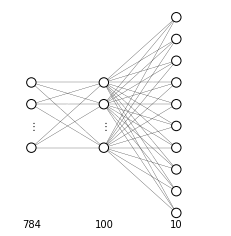

In [51]:
architecture = [4, 4, 10]
ax, _, _ = ann(
    architecture,
    node_colors=list("kkwk" * 2),
    node_labels=["", "", "$\\vdots$", ""] * 2,
    edge_colors=list("kkwk" * 2 + "wwww" + "kkwk" + "k" * 20 + "w" * 10 + "k" * 10),
    layer_labels=[784, 100, 10],
)
ax.set_aspect("equal")

Our model architecture will be:

In [52]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Non-linearity
        self.sigmoid = nn.Sigmoid()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)

        # Non-linearity  # NON-LINEAR
        out = self.sigmoid(out)

        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out

MNIST dataset is composed of images of $28 \times 28$ pixel. Each one of these images are encoded in a vector $x^{(i)} \in \mathbb{R}^{28\cdot28}$ , which will be mapped on a hidden layer and then on the output layer. The output layer must encode for 10 output classes and it is therefore a vector  $ \hat{y}^{(i)} \in \mathbb{R}^{10}$. The hidden layer can have any dimension we want, in this case we decide to have 100 hidden units, so that the input vector will be mapped to a vector $x^{(i)[1]} \in \mathbb{R}^{100}$

In [53]:
input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

The Loss function $\mathcal{L}$ of our choice is [Cross entropy loss](https://en.wikipedia.org/wiki/Cross_entropy)

In [54]:
criterion = nn.CrossEntropyLoss()

Learning rate is the speed at which the algorithm learns, setting it too high would result gradient descent being unable to land on the minimum loss, while setting it to small would result in a very slow learning process

In [55]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

We are ready to start the training process

For each epoch we expoit the `DataLoader` to iterate over mini-batches. Then for each mini-batch

1. we compute the model output `model(images)` for the images in the mini-batch
2. we compute the distance $\mathcal{L}$ `criterion(outputs, labels)` between predictions and labels
3. we compute the gradient that will bring us closer to the labels `loss.backward()`
4. we update the parameters in the direction indicated by the gradients `optimizer.step()`

In [56]:
iter = 0
losses = []
accuracies = []
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28 * 28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        losses.append(loss.item())

        if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images with gradient accumulation capabilities
                images = images.view(-1, 28 * 28).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()
                accuracy = correct / total
                accuracies.append(accuracy)

            # Print Loss
            print(
                "Iteration: {}. Loss: {}. Accuracy: {}".format(
                    iter, loss.item(), accuracy
                )
            )

Iteration: 500. Loss: 0.6400718688964844. Accuracy: 0.8641999959945679
Iteration: 1000. Loss: 0.43419456481933594. Accuracy: 0.8948000073432922
Iteration: 1500. Loss: 0.4028102457523346. Accuracy: 0.9046000242233276
Iteration: 2000. Loss: 0.20865440368652344. Accuracy: 0.9110000133514404


We can optionally store the values of $\mathcal{L}$ at each iteration to later plot its progress

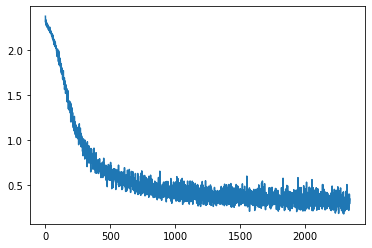

In [58]:
plt.plot(losses);